In [1]:
import segmentation_models as sm
from sklearn.model_selection import train_test_split

from brainseg.generator import TrainGenerator, TestGenerator
from brainseg.loader import Loader
from brainseg.utils import load_data, show_batch
from brainseg.image_provider import ImageHandler
from brainseg.provider import provider
from brainseg.streamlit.manager import list_all

import matplotlib.pyplot as plt
import numpy as np
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize

sm.set_framework("tf.keras")

2022-06-07 15:17:16.995248: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-07 15:17:16.995275: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Segmentation Models: using `keras` framework.


In [2]:
from brainseg.deepunet2 import unet_model

In [3]:
model = unet_model(n_classes=1, im_sz=576, n_channels=3, n_filters_start=32, growth_factor=1.2, upconv=True)
model.compile(
    Adam(learning_rate=1e-4),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

2022-06-07 15:17:20.089865: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nathan/.cache/pypoetry/virtualenvs/brainseg-XuOkmMtq-py3.8/lib/python3.8/site-packages/cv2/../../lib64:
2022-06-07 15:17:20.089896: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-07 15:17:20.089917: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nathan-SBRI): /proc/driver/nvidia/version does not exist


In [4]:
sh = ImageHandler()
provider.register(sh)

In [5]:
seq = iaa.Sequential([
    iaa.Invert(),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Rot90([0, 1, 2, 3]),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-10, 10),
        shear=(-4, 4),
        cval=255,
    ),
    iaa.Invert(),
])

In [6]:
def preprocess_augment(x, y):
    x = np.asarray(x)
    y = 255 - np.asarray(y)
    
    seg = SegmentationMapsOnImage(y, shape=y.shape)
    x, y = seq(image=x, segmentation_maps=seg)
    y = 255 - y.arr
    x = x / 255.
    y = y / 255.
    x = resize(x, (576, 576))
    y = resize(y, (576, 576))
    
    y = y.astype(np.float64)[:, :, :1]
    return x, y

In [7]:
def preprocess(x, y):
    x = np.asarray(x) / 255.
    y = np.asarray(y) / 255.
    x = resize(x, (576, 576))
    y = resize(y, (576, 576))
    y = y.astype(np.float64)[:, :, :1]
    # x, y = seq(image=x, segmentation_maps=y)
    return x, y

In [8]:
dataset = list_all("/media/nathan/LaCie/Data/wm_curated_x8_576/", min_threshold=10)

In [9]:
len(dataset)

1004

In [10]:
s = list([x[1]["data_name"][:14] for x in dataset])
from collections import Counter
Counter(s)

Counter({'M148 LHRH312.c': 34,
         'M148 LHRH266.c': 32,
         'M148 LHRH278.c': 34,
         'M148 LHRH264.c': 32,
         'M148 LHRH268.c': 30,
         'M148 LHRH232.c': 30,
         'M148 LHRH252.c': 34,
         'M148 LHRH296.c': 30,
         'M148 LHRH244.c': 30,
         'M148 LHRH292.c': 30,
         'M148 LHRH300.c': 24,
         'M148 LHRH304.c': 28,
         'M148 LHRH316.c': 30,
         'M148 LHRH320.c': 31,
         'M148 LHRH280.c': 32,
         'M148 LHRH302.c': 31,
         'M148 LHRH254.c': 32,
         'M148 LHRH310.c': 32,
         'M148 LHRH248.c': 30,
         'M148 LHRH314.c': 30,
         'M148 LHRH240.c': 31,
         'M148 LHRH318.c': 31,
         'M148 LHRH306.c': 30,
         'M148 LHRH256.c': 31,
         'M148 LHRH272.c': 29,
         'M148 LHRH286.c': 30,
         'M148 LHRH260.c': 35,
         'M148 LHRH308.c': 31,
         'M148 LHRH258.c': 18,
         'M148 LHRH236.c': 31,
         'M148 LHRH288.c': 31,
         'M148 LHRH276.c': 28,
        

In [11]:
print(len(dataset))

1004


In [12]:
train_dataset, test_dataset = train_test_split(dataset, random_state=0)

In [13]:
len(train_dataset)

753

In [14]:
train_gen = TrainGenerator(Loader(train_dataset), batch_size=4, preprocess=preprocess_augment)
test_gen = TestGenerator(Loader(test_dataset), batch_size=4, preprocess=preprocess)

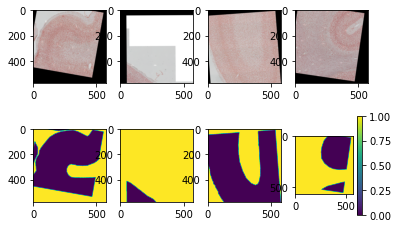

In [15]:
show_batch(train_gen[0])

In [16]:
model = unet_model(n_classes=1, im_sz=576, n_channels=3, n_filters_start=32, growth_factor=1.2, upconv=True)
model.compile(
    Adam(learning_rate=1e-4),
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 576, 576, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_64 (Conv2D)             (None, 576, 576, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_125 (Batch  (None, 576, 576, 32  128        ['conv2d_64[0][0]']              
 Normalization)                 )                                                           

                                                                                                  
 add_26 (Add)                   (None, 288, 288, 38  0           ['batch_normalization_135[0][0]',
                                )                                 'batch_normalization_133[0][0]']
                                                                                                  
 leaky_re_lu_69 (LeakyReLU)     (None, 288, 288, 38  0           ['add_26[0][0]']                 
                                )                                                                 
                                                                                                  
 batch_normalization_136 (Batch  (None, 288, 288, 38  152        ['leaky_re_lu_69[0][0]']         
 Normalization)                 )                                                                 
                                                                                                  
 conv2d_70

                                )                                                                 
                                                                                                  
 batch_normalization_148 (Batch  (None, 144, 144, 46  184        ['conv2d_75[0][0]']              
 Normalization)                 )                                                                 
                                                                                                  
 leaky_re_lu_75 (LeakyReLU)     (None, 144, 144, 46  0           ['batch_normalization_148[0][0]']
                                )                                                                 
                                                                                                  
 conv2d_76 (Conv2D)             (None, 144, 144, 46  19090       ['leaky_re_lu_75[0][0]']         
                                )                                                                 
          

                                                                                                  
 batch_normalization_160 (Batch  (None, 36, 36, 55)  220         ['dropout_15[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_82 (Conv2D)             (None, 36, 36, 66)   32736       ['batch_normalization_160[0][0]']
                                                                                                  
 batch_normalization_161 (Batch  (None, 36, 36, 66)  264         ['conv2d_82[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu_81 (LeakyReLU)     (None, 36, 36, 66)   0           ['batch_normalization_161[0][0]']
          

                                                                                                  
 conv2d_89 (Conv2D)             (None, 18, 18, 79)   56248       ['leaky_re_lu_88[0][0]']         
                                                                                                  
 batch_normalization_175 (Batch  (None, 18, 18, 79)  316         ['conv2d_89[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_173 (Batch  (None, 18, 18, 79)  316         ['leaky_re_lu_86[0][0]']         
 Normalization)                                                                                   
                                                                                                  
 add_34 (Add)                   (None, 18, 18, 79)   0           ['batch_normalization_175[0][0]',
          

 leaky_re_lu_95 (LeakyReLU)     (None, 9, 9, 95)     0           ['batch_normalization_188[0][0]']
                                                                                                  
 conv2d_96 (Conv2D)             (None, 9, 9, 95)     81320       ['leaky_re_lu_95[0][0]']         
                                                                                                  
 batch_normalization_189 (Batch  (None, 9, 9, 95)    380         ['conv2d_96[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_187 (Batch  (None, 9, 9, 95)    380         ['add_36[0][0]']                 
 Normalization)                                                                                   
                                                                                                  
 add_37 (A

                                                                  'add_33[0][0]']                 
                                                                                                  
 batch_normalization_200 (Batch  (None, 36, 36, 131)  524        ['concatenate_7[0][0]']          
 Normalization)                                                                                   
                                                                                                  
 conv2d_102 (Conv2D)            (None, 36, 36, 65)   76700       ['batch_normalization_200[0][0]']
                                                                                                  
 batch_normalization_201 (Batch  (None, 36, 36, 65)  260         ['conv2d_102[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 leaky_re_

 batch_normalization_214 (Batch  (None, 72, 72, 54)  216         ['conv2d_108[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu_108 (LeakyReLU)    (None, 72, 72, 54)   0           ['batch_normalization_214[0][0]']
                                                                                                  
 conv2d_109 (Conv2D)            (None, 72, 72, 54)   26298       ['leaky_re_lu_108[0][0]']        
                                                                                                  
 batch_normalization_215 (Batch  (None, 72, 72, 54)  216         ['conv2d_109[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 add_44 (Add)                   (None, 144, 144, 45  0           ['batch_normalization_225[0][0]',
                                )                                 'batch_normalization_223[0][0]']
                                                                                                  
 leaky_re_lu_114 (LeakyReLU)    (None, 144, 144, 45  0           ['add_44[0][0]']                 
                                )                                                                 
                                                                                                  
 batch_normalization_226 (Batch  (None, 144, 144, 45  180        ['leaky_re_lu_114[0][0]']        
 Normalization)                 )                                                                 
                                                                                                  
 conv2d_115 (Conv2D)            (None, 144, 144, 45  18270       ['batch_normalization_226[0][0]']
          

                                                                                                  
 conv2d_120 (Conv2D)            (None, 288, 288, 37  12358       ['batch_normalization_236[0][0]']
                                )                                                                 
                                                                                                  
 batch_normalization_238 (Batch  (None, 288, 288, 37  148        ['conv2d_120[0][0]']             
 Normalization)                 )                                                                 
                                                                                                  
 leaky_re_lu_120 (LeakyReLU)    (None, 288, 288, 37  0           ['batch_normalization_238[0][0]']
                                )                                                                 
                                                                                                  
 conv2d_12

                                )                                                                 
                                                                                                  
 conv2d_126 (Conv2D)            (None, 576, 576, 30  8130        ['leaky_re_lu_125[0][0]']        
                                )                                                                 
                                                                                                  
 batch_normalization_249 (Batch  (None, 576, 576, 30  120        ['conv2d_126[0][0]']             
 Normalization)                 )                                                                 
                                                                                                  
 batch_normalization_247 (Batch  (None, 576, 576, 30  120        ['add_48[0][0]']                 
 Normalization)                 )                                                                 
          

In [ ]:
for i in range(10):
    model.fit(train_gen, use_multiprocessing=True, workers=8)
    res = model.evaluate(test_gen)
    iou = "{:.3f}".format(res[1])
    model.save_weights(f"/media/nathan/LaCie/Data/models/model_deepres_x8_576_e{i}_iou{iou}.h5")

  5/188 [..............................] - ETA: 1:22:58 - loss: 1.7711 - iou_score: 0.3674

In [ ]:
res = model.evaluate(test_gen)

In [ ]:
# model.load_weights("/media/nathan/LaCie/Data/models/model_deep_x8_576_e8_iou0.793.h5")

In [ ]:
preds = model.predict(test_gen)

In [ ]:
b = test_gen[0]

len(b[0])

show_batch((b[0], preds[:4]))

In [ ]:
show_batch(b)